In [1]:
import numpy as np
import tensorflow as tf

# amazingly, this fixes plotting on Harish's Mac!
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
rs = np.loadtxt('myrALL.csv',delimiter=',')
rs1 = np.reshape(rs, [10,20001,2])
rs2 = np.transpose(rs1, (1,0,2))

qtrain = np.expand_dims(rs2[:,[0],[0]],1)
ptrain = np.expand_dims(rs2[:,[0],[1]],1)
print(qtrain.shape)
print(ptrain.shape)

n_steps = 20001
n_instances = 1
d = 1
dt = 0.001

(20001, 1, 1)
(20001, 1, 1)


In [3]:
# this function seeks to ensure reproducibility
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [31]:
def tf_diff_axis_0(a):
    return a[1:]-a[:-1]

# set up a neural network model for a potential function V : R^d --> R
reset_graph()

# here we take both q and p to be n_steps x n_instances x d
qts = tf.placeholder(tf.float32, shape=(None, n_instances, d), name="qts")
pts = tf.placeholder(tf.float32, shape=(None, n_instances, d), name="pts")

# flatten in such a way that we get a two-dimensional matrix consisting of blocks
# each block consists of one instance of dimension n_steps x d
# the number of such blocks is n_instances
q = tf.transpose(tf.layers.flatten(tf.transpose(qts, perm=[2, 1, 0])),perm=[1, 0])

# put the inputs in output[0]
output = []
output.append(q)

# here is a little Python magic that enables us to define a new function
# called "my_dense_layer" which is the same as the TF function tf.layers.dense
# except that we have preset activation=selu
# ...in short, we have partially evaluated tf.layers.dense...
from functools import partial
my_dense_layer = partial(tf.layers.dense) #,activation=tf.nn.tanh)

depth = 2
numneurons = [16, 16]

# here is where we define our deep neural network
with tf.name_scope("dnn"):
    
    # we iteratively create hidden layers
    for j in range(depth):
        thisname = "hidden" + str(j)
        
        # the input to hidden layer j is outputs[j]
        # the output of hidden layer j is stored in outputs[j+1]
        # this function handles the creation of all weight and bias variables,
        # for each hidden layer!
        if j == (depth-1):
            myact = tf.nn.softplus
        else:
            myact = tf.nn.softplus
        output.append(my_dense_layer(output[j], 
                                     units=numneurons[j],
                                     name=thisname,
                                     activation=myact))

    # to get from the high-dimensional output of the final hidden layer
    # to a scalar output, we use this function, which basically uses 
    # a linear transformation of the form "w^T h + b"
    # --> h is the vector of outputs from the last hidden layer
    # --> w is a weight vector of the same dimension as h
    # --> b is a scalar
    Vpredraw0 = tf.layers.dense(output[depth], units=1, name='output')
    Vpredraw = tf.exp(Vpredraw0)
    Vpred = tf.reshape(Vpredraw, shape=[n_instances, n_steps])
    
# automatically differentiate potential and generate gradV : R^d --> R^d
from tensorflow.python.ops.parallel_for.gradients import jacobian, batch_jacobian
gradVpredraw = batch_jacobian(Vpredraw, q)
gradVpred = tf.reshape(gradVpredraw, shape=[n_instances, n_steps, d])

# compute loss and set up optimizer
pdot = tf_diff_axis_0(pts)/dt
loss = tf.reduce_mean( tf.square( pdot + tf.transpose(gradVpred[:,:-1], perm=[1,0,2]) ) )
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(loss)

In [32]:
saver = tf.train.Saver()

In [33]:
# here we grab the final model from disk and extract three things:
# the true values of x, the true values of y, and the predicted values of y
# n = 10
with tf.Session() as sess:
    saver.restore(sess, "./rompot_model_final.ckpt")
    # xp = np.reshape(np.linspace(-4.0,4.0,n),[1,n,1])
    Vplot = sess.run(Vpred, feed_dict = {qts : qtrain})

qdatpts = np.reshape(np.transpose(qtrain,(1,0,2)),[n_instances*n_steps, 1])
Vplotpts = np.reshape(Vplot,[n_instances*n_steps])

INFO:tensorflow:Restoring parameters from ./rompot_model_final.ckpt


In [83]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


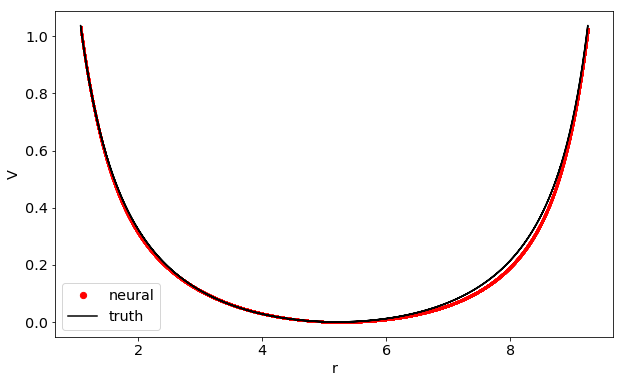

In [92]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6)) 
plt.plot(qdatpts,Vplotpts - np.min(Vplotpts),'r.',ms=2.5, label='neural')

r = qdatpts # np.linspace(1,9,1000)
l = np.sqrt(93103091.)/10000
Veff = 1./r + 1./(10-r) + l*l/(2*r*r)
plt.plot(r, Veff - np.min(Veff),'k-',lw=1.5, label='truth')
# plt.plot(np.sort(qdatpts),0.5*np.sort(qdatpts)**2,'k-',lw=1.0)
plt.legend(markerscale=5)
plt.xlabel('r')
plt.ylabel('V')
plt.savefig('romplot.pdf')
plt.show()

In [86]:
0.5*l*l

0.46551545499999997

In [39]:
cellkernels = []
cellbiases = []
with tf.Session() as sess:                           
    saver.restore(sess, "./rompot_model_final.ckpt")
    gr = tf.get_default_graph()
    for op in gr.get_operations():
        print(str(op.name))
    
    for i in range(depth):
        kernelname = 'hidden'+str(i)+'/kernel:0'
        biasname = 'hidden'+str(i)+'/bias:0'
        cellkernels.append(gr.get_tensor_by_name(kernelname).eval())
        cellbiases.append(gr.get_tensor_by_name(biasname).eval())
        
    kernel_val = gr.get_tensor_by_name('output/kernel:0').eval()
    bias_val = gr.get_tensor_by_name('output/bias:0').eval()
#     for op in gr.get_operations():
#         print(str(op.name))

INFO:tensorflow:Restoring parameters from ./rompot_model_final.ckpt
qts
pts
transpose/perm
transpose
flatten/Reshape/shape
flatten/Reshape
transpose_1/perm
transpose_1
hidden0/kernel/Initializer/random_uniform/shape
hidden0/kernel/Initializer/random_uniform/min
hidden0/kernel/Initializer/random_uniform/max
hidden0/kernel/Initializer/random_uniform/RandomUniform
hidden0/kernel/Initializer/random_uniform/sub
hidden0/kernel/Initializer/random_uniform/mul
hidden0/kernel/Initializer/random_uniform
hidden0/kernel
hidden0/kernel/Assign
hidden0/kernel/read
hidden0/bias/Initializer/zeros
hidden0/bias
hidden0/bias/Assign
hidden0/bias/read
dnn/hidden0/MatMul
dnn/hidden0/BiasAdd
dnn/hidden0/Softplus
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/

In [43]:
def myelu(x):
    y = x*(x>=0) + (np.exp(x)-1)*(x<0)
    return y

def mysp(x):
    y = np.log(1 + np.exp(x))
    return y

In [61]:
r.shape

(1000,)

(20001, 1)


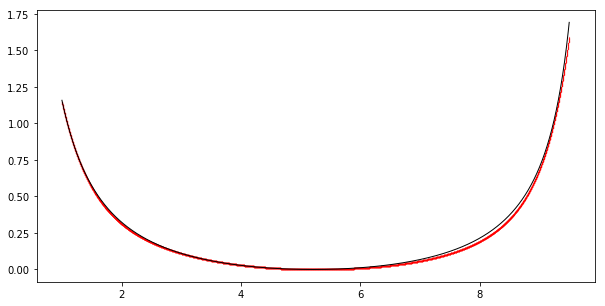

In [81]:
plt.figure(figsize=(10,5)) 
r = np.expand_dims(np.linspace(1,9.5,20001),1)
print(r.shape)
test1 = mysp(np.matmul(r, cellkernels[0]) + cellbiases[0])
test2 = mysp(np.matmul(test1, cellkernels[1]) + cellbiases[1])
test3 = np.exp(np.matmul(test2, kernel_val) + bias_val)
np.savetxt(fname='modelrompot.csv', X=test3, delimiter=',')
np.savetxt(fname='modelr.csv', X=r, delimiter=',')
plt.plot(r,test3 - np.min(test3),'r.',ms=0.25)
l = np.sqrt(93103091.)/10000
Veff = 1./r + 1./(10-r) + l*l/(2*r*r)
plt.plot(r, Veff - np.min(Veff),'k-',lw=1.0)
# plt.plot(np.sort(qdatpts),0.5*np.sort(qdatpts)**2,'k-',lw=1.0)
plt.show()

In [46]:
np.savetxt(fname='kernel0.csv', X=cellkernels[0], delimiter=',')

In [47]:
np.savetxt(fname='kernel1.csv', X=cellkernels[1], delimiter=',')

In [48]:
np.savetxt(fname='kernel2.csv', X=kernel_val, delimiter=',')

In [49]:
np.savetxt(fname='bias0.csv', X=cellbiases[0], delimiter=',')

In [50]:
np.savetxt(fname='bias1.csv', X=cellbiases[1], delimiter=',')

In [51]:
np.savetxt(fname='bias2.csv', X=bias_val, delimiter=',')

In [20]:
print(np.min(qdatpts))
print(np.max(qdatpts))

1.0682393751402417
9.255141928015705


In [52]:
import statsmodels.api as sm

In [57]:
X = np.hstack([np.ones(r.shape), 1/r, 1/(r*r), 1/(10-r)])

# Note the difference in argument order
model = sm.OLS(test3, X).fit()


In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.279e+07
Date:                Thu, 13 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:48:10   Log-Likelihood:                 71435.
No. Observations:               20001   AIC:                        -1.429e+05
Df Residuals:                   19997   BIC:                        -1.428e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2434      0.000   -924.625      0.000      -0.244      -0.243
x1             1.0160      0.001    837.276      0.000       1.014       1.018
x2             0.4411      0.001    364.416      0.000       0.439       0.443
x3             0.9810      0.000   4165.872      0.000       0.981       0.981
==============================================================================
Omnibus:                     1912.387   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              823.979
Skew:                          -0.302   Prob(JB):                    1.19e-179
Kurtosis:                       2.210   Cond. No.                         39.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""